# Detecção de fraude - cartão de crédito - Kaggle

## Introdução

Este notebook utiliza base de dados do Kaggle:
- https://www.kaggle.com/dalpozz/creditcardfraud

A base de dados contém mais de 284 mil transações de cartão de crédito contendo hora, valor e
28 atributos normalizados obtidos através de transformação PCA de redução de dimensionalidade.
Assim, ao todo são 30 atributos. O alvo do problema é prever se a transação é fraudulenta ou
genuína.
Uma característica fundamental deste dataset e que é comum em sistemas de fraudes é a diferença
entre respostas positivas: 284315 versus respostas negativas fraudulentas: 492. As fraudes 
representam apenas 0,17% das transações.
Este problema pode ser visto como sendo um problema de detecção de anomalia, entretanto iremos
tratá-la como um problema de classificação em duas classes utilizando redes neurais com
várias técnicas de regularização.

## Importação

In [1]:
%ls lib/

cifar.py       __init__.py   pytorch_utils.py       utils.py
fit_module.py  __pycache__/  pytorch_utils_test.py


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import os,sys
import time
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

#from torchvision import datasets, transforms, models

import sklearn.metrics

from lib.pytorch_utils_test import DeepNetTrainer, test_network

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


## Funções de apoio ao treinamento

In [3]:
class MyCallback(object):
    def __init__(self, interval=1):
        self.interval = interval
    
    def on_train_begin(self, trainer, has_validation=False):
        self.val = has_validation
        self.line_train = None
        self.line_valid = None
        
        self.fig = plt.figure(figsize=(15,6))
        self.ax = self.fig.add_subplot(1, 1, 1)
        self.ax.grid(True)
        self.plot_losses(trainer.metrics['train']['losses'], 
                         trainer.metrics['valid']['losses'])
    
    def on_epoch_end(self, trainer, epoch, best_epoch, t0):
        return
        display.clear_output(wait=True)
        print('n epochs:', len(trainer.metrics['train']['losses']))
        for i in range(len(trainer.metrics['train']['losses'])):
            trainer.print_losses(i)
        if epoch % self.interval == 0:
            self.plot_losses(trainer.metrics['train']['losses'],
                             trainer.metrics['valid']['losses'], best_epoch==epoch)
        
    def plot_losses(self, htrain, hvalid, best_epoch=0):
        if self.line_train: self.line_train.remove()
        if self.line_valid: self.line_valid.remove()
        
        x = np.arange(1, len(htrain) + 1)
        self.line_train, = self.ax.plot(x, htrain, color='#1f77b4', linewidth=2, label='training loss')
        self.line_valid, = self.ax.plot(x, hvalid, color='#ff7f0e', linewidth=2, label='validation loss')
        self.ax.legend()
                
        if best_epoch:
            self.ax.vlines(best_epoch, *(self.ax.get_ylim()), colors='#EBDDE2', linestyles='dashed')

        display.display(self.fig)
        time.sleep(0.1)

    def plot_losses_2(self, htrain, hvalid, best_epoch=0):
        if self.line_train is None:
            line_train = plt.plot(htrain, linewidth=2, label='training loss')
            if hvalid[0]:
                line_valid = plt.plot(hvalid, linewidth=2, label='validation loss')
        else:
            self.line_train.set_xdata(np.arange(htrain.shape[0]))
            self.line_train.set_ydata(htrain)
            if hvalid[0]:
                self.line_valid.set_xdata(np.arange(hvalid.shape[0]))
                self.line_valid.set_ydata(hvalid)
                
        if best_epoch:
            plt.vlines(best_epoch, 0, 100, colors='#EBDDE2', linestyles='dashed')
            
        plt.legend()
        
        display.display(plt.gcf())
        display.clear_output(wait=True)

## Leitura dos dados

In [4]:
dataframe = pd.read_csv('/data/datasets/creditcard.csv', header=0)
print('dataframe.shape:',dataframe.shape)
dataframe.head()

dataframe.shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### converte rótulos para codificação one-hot e conta número de amostras em cada classe

In [5]:
target = np.asarray(dataframe['Class'])
n_samples = target.shape[0]
print('n. de amostras:', n_samples)
print('transações legítimas:', (target==0).sum())
print('transações fraudulentas:', (target==1).sum())

n. de amostras: 284807
transações legítimas: 284315
transações fraudulentas: 492


### Aplica mod no Timestamp para ser uma indicação da hora diária e normaliza dados 

In [6]:
df_cp = dataframe.copy()
inputs = np.asarray(df_cp.values)[:,:-1]
timestamp = inputs[:,0]
timestamp = timestamp % (60* 60 * 24) # modulo número de segundos por dia
inputs -= inputs.min(axis=0)
inputs /= inputs.max(axis=0)
inputs[:1],inputs.shape  # dados de uma amostra normalizada

(array([[ 0.        ,  0.93519234,  0.76649042,  0.8813649 ,  0.31302266,
          0.76343873,  0.26766864,  0.26681518,  0.7864442 ,  0.47531173,
          0.51060048,  0.25248432,  0.68090763,  0.3715906 ,  0.63559053,
          0.4460837 ,  0.43439239,  0.73717255,  0.65506586,  0.59486323,
          0.58294223,  0.56118439,  0.52299212,  0.66379298,  0.39125268,
          0.58512179,  0.39455679,  0.41897614,  0.31269663,  0.00582379]]),
 (284807, 30))

### Visualiza com boxplot

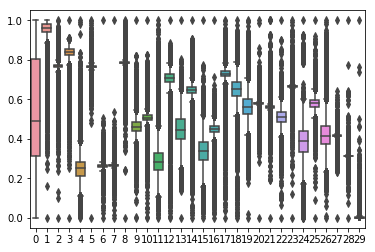

In [7]:
sns.boxplot(data=inputs[:,:]);

## Separação dados em treinamento e teste (20%)

In [8]:
i = np.arange(n_samples)
np.random.shuffle(i)

split_index = int(0.8 * n_samples)
train_i = i[:split_index]
val_i   = i[split_index:]
x_train, y_train = inputs[train_i], target[train_i]
x_val,   y_val   = inputs[val_i],   target[val_i]
print('fraudes no treino e total amostras:',    (y_train==1).sum(), y_train.shape[0])
print('fraudes na validação e total amostras:', (y_val==1).sum(),   y_val.shape[0])

fraudes no treino e total amostras: 383 227845
fraudes na validação e total amostras: 109 56962


In [9]:
batch_size = 1000 # A escolha do batch_size é crítica pois se batch_size for pequeno, só treina com legítimos
xt_train = torch.FloatTensor(x_train)
yt_train = torch.LongTensor(y_train)
train_data = TensorDataset(xt_train, yt_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

xt_val = torch.FloatTensor(x_val)
yt_val = torch.LongTensor(y_val)
val_data = TensorDataset(xt_val, yt_val)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [10]:
FEATURE_NUM = 30
CLASSES = 2

In [11]:
print('N amostras treinamento e validação:',len(train_data),len(val_data))
n=0
for k,batch in enumerate(train_loader):
    n = n + len(batch[0]) # comprimento de cada batch, 0 para pegar inputs
print('Número de batches e número de amostras:',k,n)

N amostras treinamento e validação: 227845 56962
Número de batches e número de amostras: 227 227845


## Definição da rede

In [96]:
class Model2(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bn1   = nn.BatchNorm1d(FEATURE_NUM)
        self.ln1   = nn.Linear(FEATURE_NUM,100)
        self.bn2   = nn.BatchNorm1d(100, momentum=0.01)
        self.ln2   = nn.Linear(100,100)
        self.ln3   = nn.Linear(100,50)
        self.ln4   = nn.Linear(50,CLASSES)

    def forward(self, x):
        #x = self.bn1(x)         # (FEATURE_NUM,FEATURE_NUM)
        
        x = self.ln1(x)         # (FEATURE_NUM,100)
        x = F.relu(x)
        x = F.dropout(x,0.5)  
        x = self.bn2(x)         # (100,100)
        
        x = self.ln2(x)         # (100,100)
        x = F.relu(x)
        x = F.dropout(x,0.5)
        
        x = self.ln3(x)         # (100,50)
        x = F.relu(x)
        x = F.dropout(x,0.5)
        
        x = self.ln4(x)         # (50,2)
        return x

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.ln1   = nn.Linear(FEATURE_NUM,100)
        self.do1   = nn.AlphaDropout(0.3)
        self.ln2   = nn.Linear(100,100)
        self.do2   = nn.AlphaDropout(0.3)
        self.ln2_1   = nn.Linear(100,100)
        self.do2_1   = nn.AlphaDropout(0.3)
        self.ln2_2   = nn.Linear(100,100)
        self.do2_2   = nn.AlphaDropout(0.3)
        self.ln3   = nn.Linear(100,50)
        self.do3   = nn.AlphaDropout(0.3)
        self.ln4   = nn.Linear(50,CLASSES)

    def forward(self, x):
        
        x = self.ln1(x)         # (FEATURE_NUM,100)
        x = F.selu(x)
        x = self.do1(x)  
        
        x = self.ln2(x)         # (100,100)
        x = F.selu(x)
        x = self.do2(x)
        
        x = self.ln2_1(x)         # (100,100)
        x = F.selu(x)
        x = self.do2_1(x)
 
        x = self.ln2_2(x)         # (100,100)
        x = F.selu(x)
        x = self.do2_2(x)
 
        x = self.ln3(x)         # (100,50)
        x = F.selu(x)
        x = self.do3(x)
        
        x = self.ln4(x)         # (50,2)
        return x

model = Model()
if use_gpu:
    model.cuda()
model

Model (
  (ln1): Linear (30 -> 100)
  (do1): AlphaDropout (p = 0.3)
  (ln2): Linear (100 -> 100)
  (do2): AlphaDropout (p = 0.3)
  (ln2_1): Linear (100 -> 100)
  (do2_1): AlphaDropout (p = 0.3)
  (ln2_2): Linear (100 -> 100)
  (do2_2): AlphaDropout (p = 0.3)
  (ln3): Linear (100 -> 50)
  (do3): AlphaDropout (p = 0.3)
  (ln4): Linear (50 -> 2)
)

## Testando um predict

In [97]:
if use_gpu:
    y = model(Variable(train_data[0:1][0]).cuda())
else:
    y = model(Variable(train_data[0:1][0]))
print(y)
print(F.softmax(y))

Variable containing:
 0.0992  0.2201
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]

Variable containing:
 0.4698  0.5302
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]



## Treinamento

In [98]:
def confmatrix_prec_recall(y,y_pred):
    ''' Compute Confusion Matrix, Precision and Recall'''
    n = len(y)
    assert n == len(y_pred)
    xy = y_pred + 2* y
    cm = np.bincount(xy,minlength=4)
    precision = cm[3]/(cm[3]+cm[1]+sys.float_info.epsilon)
    recall = cm[3]/(cm[3]+cm[2]+sys.float_info.epsilon)
    return cm.reshape(2,2), precision, recall

def compute_accuracy(logits, labels):
    _, preds = torch.max(logits.data, 1)
    return (preds == labels.data).type(torch.FloatTensor).mean()

def compute_confmatrix_prec_recall(logits, labels):
    _, preds = torch.max(logits.data, 1)
    preds = preds.cpu()
    labels = labels.cpu()
    return confmatrix_prec_recall(labels.data.numpy(), preds.numpy())

def compute_precision(logits, labels):
    _, p, r = compute_confmatrix_prec_recall(logits, labels)
    return p


In [99]:
w_class = torch.FloatTensor(np.array([0.3, 0.7])).cuda()
print(w_class)


 0.3000
 0.7000
[torch.cuda.FloatTensor of size 2 (GPU 0)]



In [102]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)
criterion = nn.CrossEntropyLoss(weight=Variable(w_class))
trainer = DeepNetTrainer(
        file_basename = '../../models/creditcardfraud_pt',
        model =         model,
        criterion =     criterion,
        metrics =       dict(acc=compute_accuracy),
        optimizer =     optimizer,
        lr_scheduler =  scheduler,
        callbacks =     [MyCallback()],
        reset =         False
        )

Model loaded from ../../models/creditcardfraud_pt.model


Starting training for 10 epochs

  5:   0.0s   T: 0.00678 0.99931   V: 0.01878 0.99923 best


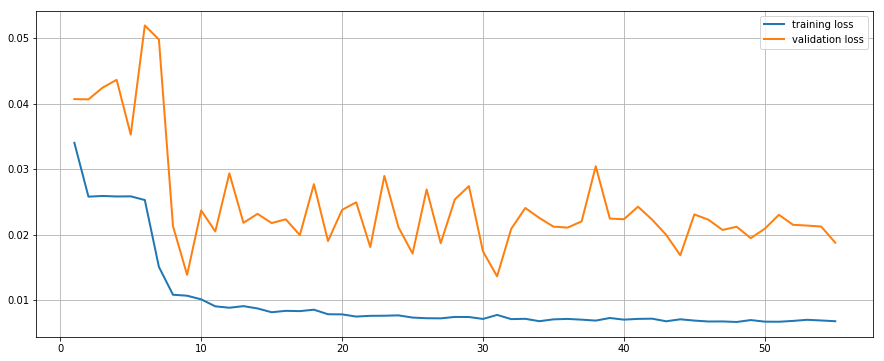

  6:   1.4s   T: 0.00645 0.99936   V: 0.02424 0.99919 
  7:   1.3s   T: 0.00679 0.99931   V: 0.02046 0.99912 
  8:   1.4s   T: 0.00666 0.99934   V: 0.02028 0.99919 
  9:   1.3s   T: 0.00677 0.99935   V: 0.02047 0.99919 
 10:   1.3s   T: 0.00682 0.99935   V: 0.02105 0.99914 
 11:   1.3s   T: 0.00660 0.99933   V: 0.02201 0.99914 
 12:   1.3s   T: 0.00661 0.99933   V: 0.02130 0.99912 
 13:   1.3s   T: 0.00687 0.99929   V: 0.02016 0.99911 
 14:   1.3s   T: 0.00663 0.99932   V: 0.01914 0.99919 
 15:   1.3s   T: 0.00667 0.99936   V: 0.01854 0.99914 best

Model from epoch 15 saved as "../../models/creditcardfraud_pt.*", loss = 0.01854


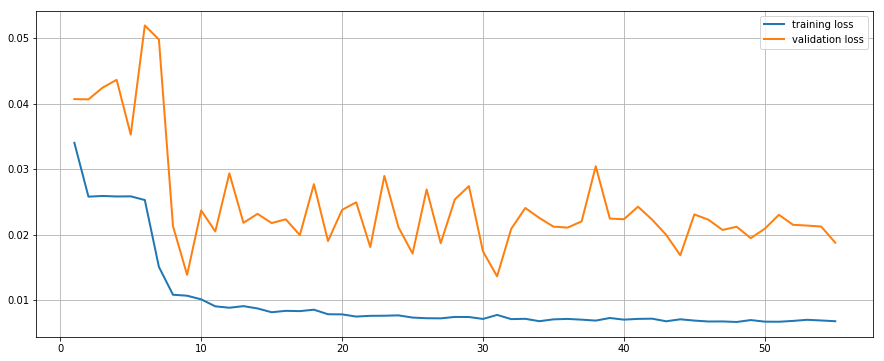

In [111]:
trainer.fit(10, train_loader, val_loader)


## Avaliação


<table border="1px">
<tr>
    <th> </th> <th> </th> <th colspan="2">Dataset</th>
</tr><tr>
    <th> </th> <th> </th>                                 <th>Legítima (0)</th> <th>Fraude (1)</th>
</tr><tr>
<th rowspan="4">Detecção </th> <th rowspan="2"> Negativo (0)  </th> <th>VN   </th> <th>FN</th>
</tr><tr>
                                                      <th>(legítima correta)</th> <th>(fraude não detectada)</th>
</tr><tr>
                               <th rowspan="2"> Positivo (1)  </th> <th>FP   </th> <th>VP</th>
</tr><tr>
                                                          <th>(alarme falso)   </th> <th>(fraude detectada)</th>
</tr>
</table>

- Amostras: $M = VP+VN+FP+FN$
- Acurácia ou Exatidão: $ACC = \frac{VP+VN}{M} $ Detecções corretas sobre o total
- Precisão: $P  = \frac{VP}{VP+FP}$ Taxa de fraudes detectadas são realmente fraudes (não quer perder vendas)
- Sensibilidade:$S  = \frac{VP}{VP+FN} $ Capacidade de detectar todas as fraudes (não quer perder dinheiro)

In [112]:
metrics = trainer.evaluate(train_loader)
print('Model training set accuracy after training: {:.5f}'.format(metrics['acc']))
print()
metrics = trainer.evaluate(val_loader)
print('Model validation set accuracy after training: {:.5f}'.format(metrics['acc']))

evaluate: 227/227 ok
Model training set accuracy after training: 0.99935

evaluate: 56/56 ok
Model validation set accuracy after training: 0.99914


In [113]:
cm = trainer.evaluate_confusion_matrix(train_loader)
print(cm)

predict: 227/227 ok
[[227387     75]
 [    72    311]]


In [114]:
cm = trainer.evaluate_confusion_matrix(val_loader)
print(cm)

predict: 56/56 ok
[[56825    28]
 [   21    88]]


In [21]:
def evaluate_loss(model, criterion, dataloader):
    loss = 0
    n = 0
    model.train(False)

    for k,(x,y) in enumerate(dataloader):
        if use_gpu:
            x, y = Variable(x.cuda()), Variable(y.cuda())
        else:
            x, y = Variable(x), Variable(y)

        y_pred = model(x)
        nn = y_pred.size(0)
        mb_loss = criterion(y_pred, y)
                                
        loss += mb_loss * nn
        n += nn
    loss /= n
    return loss

In [22]:
new_model = Model()
if use_gpu:
    new_model.cuda()

loss_train = evaluate_loss(trainer.model, criterion, train_loader)
loss_val =   evaluate_loss(trainer.model, criterion, val_loader)

In [23]:
lt = loss_train.cpu()
lv = loss_val.cpu()
print('{:.5f} {:.5f}'.format(lt.data.numpy()[0], lv.data.numpy()[0]) )

0.02523 0.03141


## Aprendizados